In [5]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tensorflow import keras as k
from tensorflow.keras import layers
import seaborn as sns

tf.enable_eager_execution()
print(tf.executing_eagerly())

print(tf.__version__)
print(k.__version__)
print(tf.test.is_gpu_available())

True
1.15.0
2.2.4-tf
True


In [0]:
BATCH_SIZE = 128
SIZE = 28
LATENT_DIM = 10

In [0]:
### loading mnist data
(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1,28,28,1)).astype('float32')
test_images = test_images.reshape((-1,28,28,1)).astype('float32')
train_images /= 255.
test_images /= 255.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as k
from tensorflow.keras import layers

def make_model(SIZE=28, LATENT_DIM=10, LR=1e-4, BETA=1.):
    encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
    e = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
    e = layers.BatchNormalization()(e)
    e = layers.Conv2D(filters=32,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(e)
    e = layers.BatchNormalization()(e)
    e = layers.Flatten()(e)
    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(e)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(e)
    encoder = k.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')


    decoder_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
    d = layers.Dense(units=7*7*4,activation='relu')(decoder_inputs)
    d = layers.Reshape((7,7,4))(d)
    d = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    d = layers.Conv2DTranspose(filters=32,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    decoded = layers.Conv2DTranspose(filters=1, kernel_size=3,strides=(1, 1), padding="SAME")(d)
    decoder = k.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')


    def sample(inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    sampler = layers.Lambda(sample)
    z = sampler([z_mean, z_log_var])
    vae = k.Model(inputs=encoder_inputs, outputs=decoder(z), name='vae')

    def compute_kernel(x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
        tiled_y = tf.tile(tf.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))


    def compute_mmd(x, y):
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

    true_samples = tf.random_normal(shape=tf.shape(z))
    loss_mmd = compute_mmd(true_samples, z)
    vae.add_loss(loss_mmd*BETA)
        
    vae.compile(loss='mse', optimizer=k.optimizers.Adam(LR), metrics=['mse'])
    return encoder, decoder , vae

In [9]:
encoder, decoder, vae = make_model()
losses = []
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 16)   416         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 32)     12832       batch_normalization[0][0]        
________________________________________________________________________________________________

In [10]:
for i in tqdm(range(50)):
    l = vae.fit(train_images,train_images,epochs=1,verbose=0)
    losses += [l.history['loss']]
    if (i+1) % 5 == 0:
        print(i+1, ' : ', l.history)

5  :  {'loss': [0.03834810168743134], 'mean_squared_error': [0.027875194]}
10  :  {'loss': [0.033867597290873526], 'mean_squared_error': [0.023927849]}
15  :  {'loss': [0.031746637334426245], 'mean_squared_error': [0.022253541]}
20  :  {'loss': [0.030691859987378122], 'mean_squared_error': [0.021213267]}
25  :  {'loss': [0.029686768885453543], 'mean_squared_error': [0.020468248]}
30  :  {'loss': [0.029201814863085748], 'mean_squared_error': [0.019990735]}
35  :  {'loss': [0.028598855153719585], 'mean_squared_error': [0.019565756]}
40  :  {'loss': [0.028085467776656152], 'mean_squared_error': [0.019140318]}
45  :  {'loss': [0.02778570575217406], 'mean_squared_error': [0.01884816]}
50  :  {'loss': [0.02732611355682214], 'mean_squared_error': [0.018535826]}



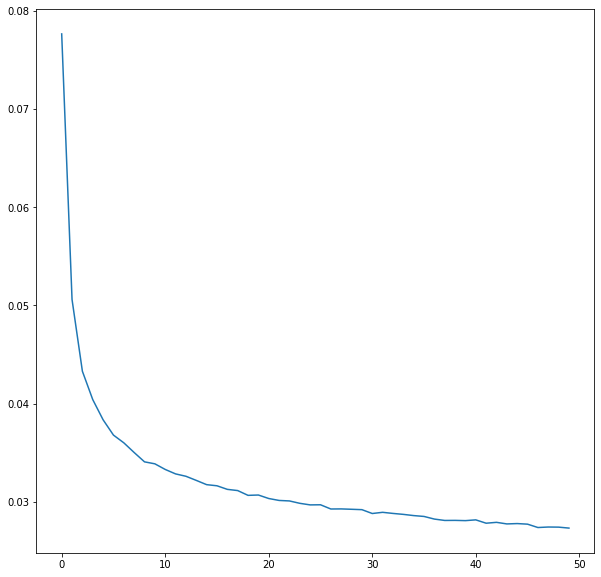

In [11]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.show()

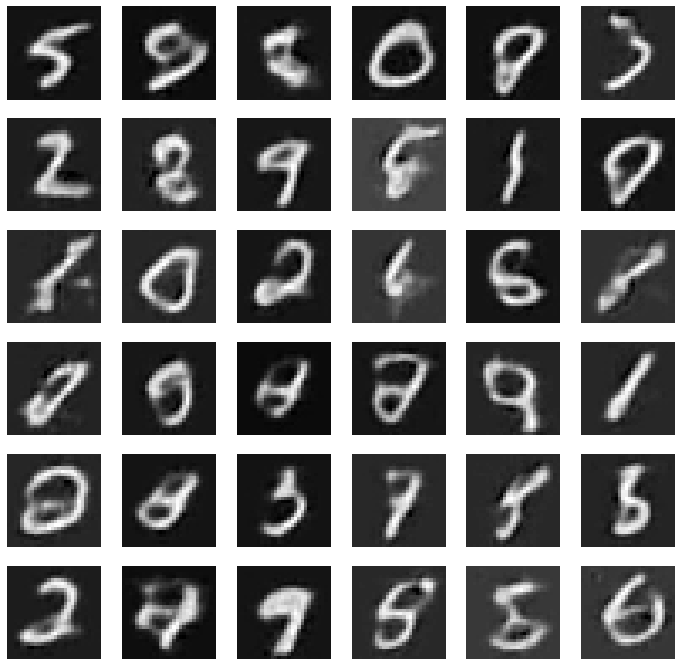

In [12]:
def generate(m,n):
    rand_vec = np.random.normal(size=(m*n, LATENT_DIM))
    gen = decoder.predict(rand_vec)
    
    plt.figure(figsize=(m*2,2*n))
    for i in range(m*n):
        plt.subplot(m, n, i+1)
        plt.imshow(gen[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
generate(6,6)

(64, 28, 28, 1)


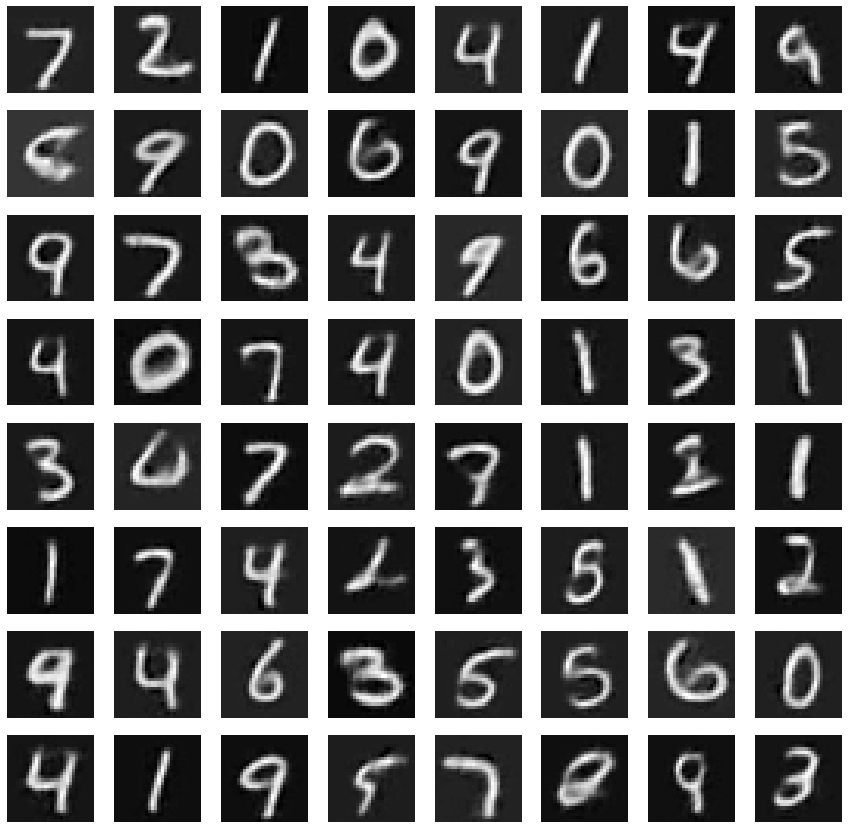

In [14]:
def reconstruct(m, n, data):
    total=m*n
    recons = vae.predict(data[:total],steps=1)
    print(recons.shape)
    
    plt.figure(figsize=(15, 15))
    for i in range(total):
        plt.subplot(m, n, i+1)
        plt.imshow(recons[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()

reconstruct(8,8,test_images)

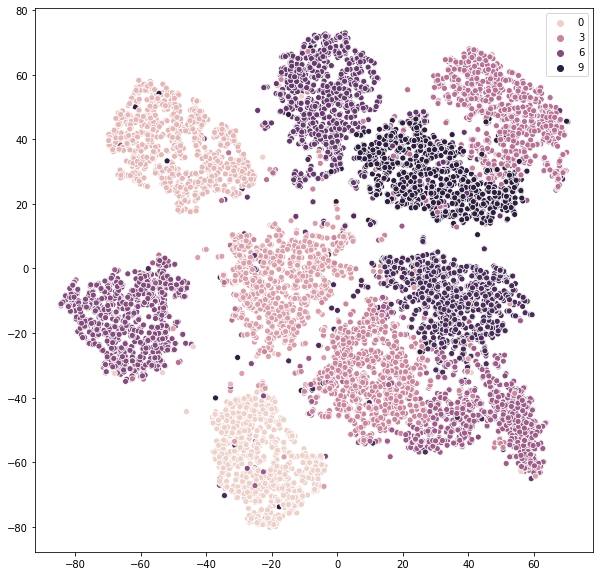

In [21]:
# Test dataset
from sklearn.manifold import TSNE

# mean, _ = encoder.predict(test_images)
# points = TSNE(n_components=2).fit_transform(mean)
# print(points.shape)

plt.figure(figsize=(10,10))
cmap = sns.color_palette("hls", 10)
sns.scatterplot(x=points[:,0], y=points[:,1], hue=y_test, cmap=cmap)
plt.show()

In [20]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)